In [1]:
# This is a python block

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

# Cargar data

- cargo

In [4]:
df_data = pd.read_csv('./dataset_clean.csv', index_col=[0])

# Preprocesamiento rápido

- Resuelvo problemas con descriptores que tienen infinitos

In [5]:
filter = df_data['Vacancy energy (log[eV/O atom])'] == -np.inf
df_data['Vacancy energy (log[eV/O atom])'][filter] = np.nan

/tmp/ipykernel_2637/1743523762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Vacancy energy (log[eV/O atom])'][filter] = np.nan


In [6]:
filter = df_data['Stability (log[eV/atom])'] == -np.inf
df_data['Stability (log[eV/atom])'][filter] = np.nan

/tmp/ipykernel_2637/1119673096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Stability (log[eV/atom])'][filter] = np.nan


- Elimino nulos sí o sí (la otra alternativa sería imputar)

In [7]:
df_data.isnull().sum()

Lowest distortion                     0
A                                     0
B                                     0
Radius A [ang]                        0
Radius B [ang]                        0
Formation energy [eV/atom]            0
Stability [eV/atom]                   0
Volume per atom [A^3/atom]            0
Band gap [eV]                         0
a [ang]                               0
Vacancy energy [eV/O atom]          349
Stability (log[eV/atom])            290
Vacancy energy (log[eV/O atom])    3169
Magnetic moment (^2[mu_B])          947
Valence B_1                           0
Valence B_2                           0
Valence B_3                           0
Valence B_4                           0
Valence B_5                           0
Valence B_element not in BV           0
Valence B_not balanced                0
dtype: int64

In [8]:
df_data.drop('Vacancy energy (log[eV/O atom])', axis=1, inplace= True)

In [9]:
df_data.dropna(inplace=True)

# Split target y patrón

- Split

In [10]:
x = df_data.drop(['Lowest distortion', 'a [ang]'], axis=1)
y = df_data['a [ang]']

- Validación

In [11]:
print(x.shape)
print(y.shape)

(3720, 18)
(3720,)


# Split train y test

- Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12, shuffle = True)

- Validación

In [13]:
print(X_train.shape)
print(X_test.shape)

(2976, 18)
(744, 18)


# Escalamiento/Normalización de los datos 

- Instancio scaler para target y patron

In [14]:
x_st_scaler = StandardScaler() #Creo instancia del scaler
y_st_scaler = StandardScaler() #Creo instancia del scaler

- Escalo con fit sobre train, y trasnformo test

In [15]:
X_train = x_st_scaler.fit_transform(X_train) # escalo train
X_test = x_st_scaler.transform(X_test) #transformo test

In [16]:
y_train = y_st_scaler.fit_transform(y_train.values.reshape(-1,1)) # escalo train
y_test = y_st_scaler.transform(y_test.values.reshape(-1,1)) #transformo test

# Entrenamiento del modelo con Linear Regression

- Importo modelo de Sklearn

In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor

- Instancio modelo

In [18]:
model = HistGradientBoostingRegressor()

- Entreno

In [19]:
model.fit(X_train, y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

- Predigo

In [20]:
y_pred = model.predict(X_test)

- Evaluación rápida

In [21]:
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

r2 = metrics.r2_score(y_test, y_pred)

In [22]:
print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

mae: 	 0.1354
mse: 	 0.0992
rmse: 	 0.3149
r2: 	 0.9048


# Mejora del modelo y residuales

- Import stats model para sacar p_value

In [23]:
import statsmodels.api as sm

## Evaluación modelo 1

- Stats summary

In [24]:
y_test = y_test.reshape(-1)

In [25]:
X2 = sm.add_constant(X_test)
est = sm.OLS(y_test, X2)
est2 = est.fit()
print(est2.summary())

#dejar solo la 3,4,5,6,7,9,10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     116.2
Date:                Sat, 24 Jun 2023   Prob (F-statistic):          8.00e-194
Time:                        20:10:55   Log-Likelihood:                -581.87
No. Observations:                 744   AIC:                             1200.
Df Residuals:                     726   BIC:                             1283.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0279      0.020      1.399      0.1

- Residuales (resta entre reales y predichos)

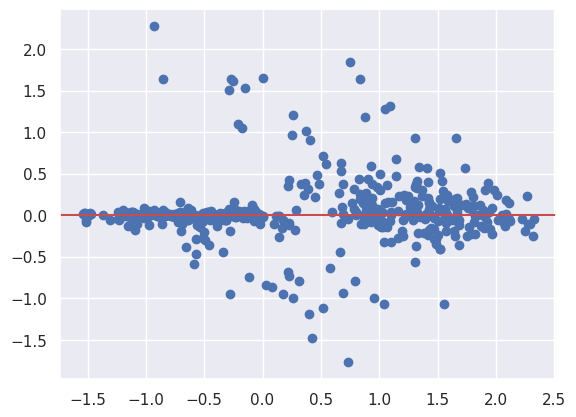

In [26]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

## Evaluación modelo 2

- Copio el df original

In [27]:
df_second = df_data.copy()

- Hago nuevo modelo usando solo las comumnas de interes

In [28]:
list(list(x))

['A',
 'B',
 'Radius A [ang]',
 'Radius B [ang]',
 'Formation energy [eV/atom]',
 'Stability [eV/atom]',
 'Volume per atom [A^3/atom]',
 'Band gap [eV]',
 'Vacancy energy [eV/O atom]',
 'Stability (log[eV/atom])',
 'Magnetic moment (^2[mu_B])',
 'Valence B_1',
 'Valence B_2',
 'Valence B_3',
 'Valence B_4',
 'Valence B_5',
 'Valence B_element not in BV',
 'Valence B_not balanced']

In [29]:
cols_str = list(list(x))[2:10]
cols_str.remove('Band gap [eV]')
cols_str

['Radius A [ang]',
 'Radius B [ang]',
 'Formation energy [eV/atom]',
 'Stability [eV/atom]',
 'Volume per atom [A^3/atom]',
 'Vacancy energy [eV/O atom]',
 'Stability (log[eV/atom])']

In [30]:
X_cols = cols_str
y_col = ['a [ang]']

x = df_second[X_cols]
y = df_second[y_col]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12, shuffle = True)

x_st_scaler = StandardScaler() #Creo instancia del scaler
y_st_scaler = StandardScaler() #Creo instancia del scaler

X_train = x_st_scaler.fit_transform(X_train) # escalo train
X_test = x_st_scaler.transform(X_test) #transformo test
y_train = y_st_scaler.fit_transform(y_train.values.reshape(-1,1)) # escalo train
y_test = y_st_scaler.transform(y_test.values.reshape(-1,1)) #transformo test

model = HistGradientBoostingRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- Evaluacióon rápida

In [31]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.898
mse:  0.1062


- Stats

In [32]:
y_test = y_test.reshape(-1)

In [33]:
X2 = sm.add_constant(X_test)
est = sm.OLS(y_test, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     283.6
Date:                Sat, 24 Jun 2023   Prob (F-statistic):          3.66e-204
Time:                        20:10:57   Log-Likelihood:                -584.27
No. Observations:                 744   AIC:                             1185.
Df Residuals:                     736   BIC:                             1221.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.020      1.221      0.2

- Residuales

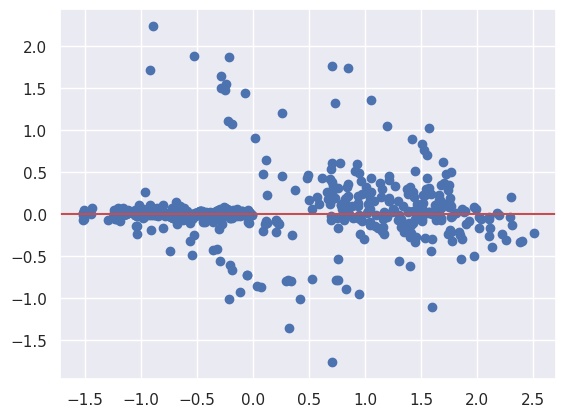

In [34]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Prueba de nuevas configuraciones para el modelo

In [44]:
x = df_data.drop(['Lowest distortion', 'a [ang]'], axis=1)
y = df_data['a [ang]']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12, shuffle = True)

x_st_scaler = StandardScaler() #Creo instancia del scaler
y_st_scaler = StandardScaler() #Creo instancia del scaler

X_train = x_st_scaler.fit_transform(X_train) # escalo train
X_test = x_st_scaler.transform(X_test) #transformo test
y_train = y_st_scaler.fit_transform(y_train.values.reshape(-1,1)) # escalo train
y_test = y_st_scaler.transform(y_test.values.reshape(-1,1)) #transformo test


- Configuración 2 ************* Óptima **************

In [45]:
model = HistGradientBoostingRegressor(max_bins= 255,max_iter= 1000,learning_rate= 0.1,max_depth= 8)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred)

print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
mae: 	 0.1391
mse: 	 0.0925
rmse: 	 0.3041
r2: 	 0.9112


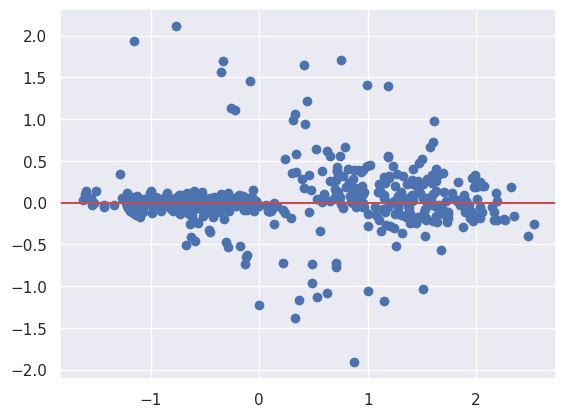

In [47]:
y_test = y_test.reshape(-1)
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

- Configuración 3

In [37]:
model = HistGradientBoostingRegressor(max_bins= 128,max_iter= 500,learning_rate= 0.05,max_depth= 6)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred)

print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
mae: 	 0.1348
mse: 	 0.0995
rmse: 	 0.3154
r2: 	 0.9045


- Configuración 4

In [38]:
model = HistGradientBoostingRegressor(max_bins= 255,max_iter= 1500,learning_rate= 0.01,max_depth= 10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred)

print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
mae: 	 0.1321
mse: 	 0.0979
rmse: 	 0.3129
r2: 	 0.906


- Configuración 5

In [39]:
model = HistGradientBoostingRegressor(max_bins= 64,max_iter= 200,learning_rate= 0.2,max_depth= 4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred)

print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
mae: 	 0.1468
mse: 	 0.0986
rmse: 	 0.314
r2: 	 0.9053


- Configuración 6

In [40]:
model = HistGradientBoostingRegressor(max_bins= 255,max_iter= 500,learning_rate= 0.05,max_depth= 6)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
r2 = metrics.r2_score(y_test, y_pred)

print("mae: \t", mae.round(4))
print("mse: \t", mse.round(4))
print("rmse: \t", rmse.round(4))
print("r2: \t", r2.round(4))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
mae: 	 0.1358
mse: 	 0.0994
rmse: 	 0.3153
r2: 	 0.9045


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a7ebb3ed-5c94-423a-a3b7-e9cd0209ff98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>